In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import sys, os
import json
import torch.nn as nn  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim

import prettytable
import time
import sys
sys.setrecursionlimit(18000)

from PIL import Image
from torch.optim import lr_scheduler
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
from torch.utils.data import random_split

from model0409 import FixCapsNet
from images_show import ImageShow

In [3]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "HAM10000"
best_acc= 0.
#defined 
try:
    print(len(test_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list=train_loss_list,
                train_acc_list=train_acc_list,
                test_loss_list=test_loss_list,
                test_acc_list=test_acc_list,
                test_auc_list=test_auc_list,
                val_loss_list=val_loss_list,
                val_acc_list=val_acc_list,
                )

In [4]:
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop((299, 299)),
                                 transforms.RandomVerticalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((308,308)),
                               transforms.CenterCrop((299, 299)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ])
    }

In [37]:
root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
image_path = os.path.abspath(os.path.join(root_path,"skin_lesion"))
assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                     transform=data_transform["train"])
test_dataset = datasets.ImageFolder(root=os.path.join(image_path,"test"),
                                      transform=data_transform["val"])
train_num = len(train_dataset)
test_num = len(test_dataset)

img_sample = Image.open(test_dataset.imgs[1][0])
n_channels = np.array(img_sample).shape[2]#(H,W,C)

data_list = train_dataset.class_to_idx #
cla_dict = dict((val, key) for key, val in data_list.items())
n_classes  = len(data_list)
print(f'Using {n_classes} types.')

# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open(f'{img_title}.json', 'w') as json_file:#class_indices
    json_file.write(json_str)

BatchSize = 168
T_size = 31
nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 8]) 
print(f'Using {nw} dataloader workers every process.')
pin_memory = True
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BatchSize,pin_memory=pin_memory,
                                           shuffle=True, num_workers=nw)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=T_size,pin_memory=pin_memory,
                                          shuffle=False, num_workers=nw)

print("using {} images for training, {} images for validation.".format(train_num, test_num))

Using 7 types.
Using 8 dataloader workers every process.
using 51699 images for training, 828 images for validation.


In [6]:
# Create capsule network.
conv_outputs = 128 #128_Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6
output_unit_size = 16
img_size = 299
network = FixCapsNet(conv_inputs= n_channels,
                     conv_outputs=conv_outputs,
                     num_primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     output_unit_size=output_unit_size,
                     num_classes=n_classes,
                     init_weights=True)

network = network.to(device)
summary(network,(n_channels,img_size,img_size))
# network

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 135, 135]         369,152
              ReLU-2        [-1, 128, 135, 135]               0
FractionalMaxPool2d-3          [-1, 128, 20, 20]               0
            Conv2d-4          [-1, 128, 20, 20]          16,384
       BatchNorm2d-5          [-1, 128, 20, 20]             256
         Hardswish-6          [-1, 128, 20, 20]               0
 AdaptiveAvgPool2d-7            [-1, 128, 1, 1]               0
            Conv2d-8            [-1, 128, 1, 1]          16,384
              ReLU-9            [-1, 128, 1, 1]               0
           Conv2d-10            [-1, 128, 1, 1]          16,384
AdaptiveMaxPool2d-11            [-1, 128, 1, 1]               0
           Conv2d-12            [-1, 128, 1, 1]          16,384
             ReLU-13            [-1, 128, 1, 1]               0
           Conv2d-14            [-1, 1

In [7]:
learning_rate = 0.123
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)

In [8]:
def confusion_matrix(evl_result):

    plt.style.use("seaborn")#classic
    plt.yticks(range(n_classes),cla_dict.values())
    plt.xticks(range(n_classes),cla_dict.values())    
    plt.title("Confusion Matrix")
    plt.imshow(evl_result,cmap=plt.cm.Greens)
    for i in range(len(evl_result)):
        for j in range(len(evl_result[i])):
            plt.text(j,i,int(evl_result[i][j]))

    plt.colorbar()
    plt.savefig(f"./tmp/{img_title}/{suf}/Confusion Matrix.png",dpi=128)

In [9]:
def self_scores(opt="scores"):
    result_table = prettytable.PrettyTable()
    result_table.field_names = ['Type','Precision', 'Recall', 'F1','Accuracy']    
    accuracy = float(torch.sum(evl_result.diagonal())/torch.sum(evl_result))

    for i in range(n_classes):
        pre = float(evl_result[i][i] / torch.sum(evl_result,0)[i])#
        recal = float(evl_result[i][i] / torch.sum(evl_result,1)[i])#torch.sum(result_table[i])
        F1 = pre * recal * 2 / (pre + recal + 1e-7)
        result_table.add_row([cla_dict[i], round(pre, 4), round(recal, 3), round(F1, 3)," "])

    result_table.add_row(["Total:", " ", " ", " ",round(accuracy,4)])
    print(result_table)

In [10]:
# Converts batches of class indices to classes of one-hot vectors.
def to_one_hot(x, length):
    batch_size = x.size(0)
    x_one_hot = torch.zeros(batch_size, length)
    for i in range(batch_size):
        x_one_hot[i, x[i]] = 1.0
    return x_one_hot

In [11]:
def train(epoch):
    network.train()
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    print(f'Epoch: [{epoch}] {img_title} ==> Training ...')
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):        
        # target = torch.as_tensor(target, dtype=torch.int64)#for windows

        batch_idx += 1
        target_indices = target
        target_one_hot = to_one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)
        optimizer.zero_grad()
        output = network(data)

        v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        
        loss = network.loss(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % print_step == 0:
            print("[{}/{}] Loss{:.5f}, ACC:{:.5f}%".format(batch_idx,len(train_loader),
                                                           loss,
                                                           r_pre/(batch_idx*BatchSize),))
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)    
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)
    
    print(f'Train_Loss: {epoch_loss},ACC:{round(float(epoch_acc),3)}%')   
    scheduler.step()

In [12]:
def test():
    network.eval()
    global best_acc,evl_result,evl_tmp_result,net_parameters
    cor_loss,correct,tmp_size, Acc=  0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    steps_num = len(test_loader)#len(test_loader) * T_size
    tmp_size = T_size
    print(f'\033[66m{img_title} ==> testing ...\033[0m')
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):

            batch_idx +=1
            target_indices = target
            #torch.Size([128, 7]),tensor([[0., 0., 0., 0., 0., 1., 0.],...,[0., 0., 0., 0., 0., 1., 0.]])
            target_one_hot = to_one_hot(target_indices, length=n_classes)            
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

            output = network(data)#torch.Size([batch_size, 7, 16, 1])        
            v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]  
               
            if batch_idx % steps_num == 0 and test_num % T_size != 0:
                tmp_size = test_num % T_size

            for i in range(tmp_size):
                pred_y = pred.numpy()         
                evl_tmp_result[target_indices[i]][pred[i]] +=1 
    
    diag_sum = torch.sum(evl_tmp_result.diagonal())
    all_sum = torch.sum(evl_tmp_result)   
    accuracy = 100. * float(torch.div(diag_sum,all_sum)) 
    test_acc_list.append(accuracy)
    
    print(f"Test_Acc:\033[1;32m{round(float(accuracy),3)}%\033[0m")

    if accuracy > best_acc:
        best_acc = accuracy
        evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
        torch.save(network.state_dict(), save_PATH)
        torch.save(evl_result, f'./tmp/{img_title}/{suf}/best_evl_result.pt')
        
    print(f'Best_ACC[\033[1;32m{round(float(best_acc),3)}%\033[0m]')

In [13]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    print(f"suf:{suf}")
if os.path.exists(f'./tmp/{img_title}/{suf}'):
    print (f'Store: ./tmp/{img_title}/{suf}')
else:
#     !mkdir -p ./tmp/{img_title}/{suf} #linux
    !md E:\Jupyter\woodman\Caps\FixCaps\tmp\{img_title}\{suf} #windows
save_PATH = f'./tmp/{img_title}/{suf}/best_{img_title}_{suf}.pth'
print(save_PATH)

suf:0430_074853
./tmp/HAM10000/0430_074853/best_HAM10000_0430_074853.pth


子目录或文件 #windows 已经存在。
处理: #windows 时出错。


In [14]:
num_epochs = 100

In [15]:
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()
print('Finished Training')

Epoch: [1] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.40259, ACC:0.31807%
[308/308] Loss0.38982, ACC:0.36727%
Train_Loss: 0.4071033077387067,ACC:0.368%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:81.159%
Best_ACC[81.159%]
Epoch: [2] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.36998, ACC:0.46347%
[308/308] Loss0.31959, ACC:0.48164%
Train_Loss: 0.33896152829969084,ACC:0.482%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:83.213%
Best_ACC[83.213%]
Epoch: [3] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.31056, ACC:0.51998%
[308/308] Loss0.30951, ACC:0.53237%
Train_Loss: 0.3098358253573442,ACC:0.533%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:86.232%
Best_ACC[86.232%]
Epoch: [4] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.29325, ACC:0.55543%
[308/308] Loss0.30013, ACC:0.55933%
Train_Loss: 0.2929197248410095,ACC:0.56%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:85.386%
Best_ACC[86.232%]
Epoch: [5] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27699, ACC:0.57939%
[308/308] Loss0.28060, ACC:0.57864%
Train_Loss: 0.282022031096669,ACC:0.579%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:86.473%
Best_ACC[86.473%]
Epoch: [6] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.30028, ACC:0.57815%
[308/308] Loss0.27570, ACC:0.57841%
Train_Loss: 0.2802017117282013,ACC:0.579%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:87.077%
Best_ACC[87.077%]
Epoch: [7] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27024, ACC:0.58221%
[308/308] Loss0.28844, ACC:0.58409%
Train_Loss: 0.27906402181108275,ACC:0.585%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:86.594%
Best_ACC[87.077%]
Epoch: [8] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27700, ACC:0.57784%
[308/308] Loss0.27876, ACC:0.57879%
Train_Loss: 0.2823703786866231,ACC:0.579%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:87.077%
Best_ACC[87.077%]
Epoch: [9] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.26353, ACC:0.57491%
[308/308] Loss0.28558, ACC:0.57746%
Train_Loss: 0.2817112553332533,ACC:0.578%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:81.763%
Best_ACC[87.077%]
Epoch: [10] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27512, ACC:0.57854%
[308/308] Loss0.27013, ACC:0.58295%
Train_Loss: 0.2795225598595359,ACC:0.583%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:84.3%
Best_ACC[87.077%]
Epoch: [11] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.29006, ACC:0.59373%
[308/308] Loss0.29130, ACC:0.59501%
Train_Loss: 0.273121959638673,ACC:0.596%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:43.841%
Best_ACC[87.077%]
Epoch: [12] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24481, ACC:0.60509%
[308/308] Loss0.26539, ACC:0.60610%
Train_Loss: 0.26583634752344776,ACC:0.607%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:85.024%
Best_ACC[87.077%]
Epoch: [13] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25041, ACC:0.62113%
[308/308] Loss0.25118, ACC:0.62384%
Train_Loss: 0.25593816440600853,ACC:0.624%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:77.899%
Best_ACC[87.077%]
Epoch: [14] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25837, ACC:0.63663%
[308/308] Loss0.24575, ACC:0.63615%
Train_Loss: 0.24791936668289172,ACC:0.637%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:87.198%
Best_ACC[87.198%]
Epoch: [15] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24921, ACC:0.64564%
[308/308] Loss0.21810, ACC:0.64440%
Train_Loss: 0.24234179828267594,ACC:0.645%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:86.715%
Best_ACC[87.198%]
Epoch: [16] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23642, ACC:0.64858%
[308/308] Loss0.24281, ACC:0.64815%
Train_Loss: 0.2402913709255782,ACC:0.649%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:87.077%
Best_ACC[87.198%]
Epoch: [17] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24062, ACC:0.64777%
[308/308] Loss0.22993, ACC:0.64879%
Train_Loss: 0.23960885120096145,ACC:0.649%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:87.923%
Best_ACC[87.923%]
Epoch: [18] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23121, ACC:0.64089%
[308/308] Loss0.25280, ACC:0.64346%
Train_Loss: 0.24380260962363962,ACC:0.644%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:88.889%
Best_ACC[88.889%]
Epoch: [19] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.28041, ACC:0.63919%
[308/308] Loss0.23282, ACC:0.63710%
Train_Loss: 0.24895956841382114,ACC:0.638%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:84.179%
Best_ACC[88.889%]
Epoch: [20] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22684, ACC:0.62937%
[308/308] Loss0.25506, ACC:0.63211%
Train_Loss: 0.2506514453365431,ACC:0.633%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:87.44%
Best_ACC[88.889%]
Epoch: [21] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23329, ACC:0.63861%
[308/308] Loss0.23989, ACC:0.63627%
Train_Loss: 0.24870004340425714,ACC:0.637%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:87.319%
Best_ACC[88.889%]
Epoch: [22] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25362, ACC:0.64672%
[308/308] Loss0.24350, ACC:0.64373%
Train_Loss: 0.24378154499383717,ACC:0.644%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:87.077%
Best_ACC[88.889%]
Epoch: [23] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24200, ACC:0.65113%
[308/308] Loss0.22793, ACC:0.65273%
Train_Loss: 0.23812312100614821,ACC:0.653%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:90.338%
Best_ACC[90.338%]
Epoch: [24] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22836, ACC:0.66640%
[308/308] Loss0.23962, ACC:0.66676%
Train_Loss: 0.22929904861496642,ACC:0.667%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:90.459%
Best_ACC[90.459%]
Epoch: [25] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20502, ACC:0.67471%
[308/308] Loss0.20761, ACC:0.67430%
Train_Loss: 0.22378487991435186,ACC:0.675%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:90.338%
Best_ACC[90.459%]
Epoch: [26] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21701, ACC:0.67420%
[308/308] Loss0.23275, ACC:0.67536%
Train_Loss: 0.22379213111934723,ACC:0.676%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:90.7%
Best_ACC[90.7%]
Epoch: [27] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20249, ACC:0.67235%
[308/308] Loss0.18818, ACC:0.67722%
Train_Loss: 0.22355340605045293,ACC:0.678%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:91.063%
Best_ACC[91.063%]
Epoch: [28] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24030, ACC:0.67111%
[308/308] Loss0.20640, ACC:0.67094%
Train_Loss: 0.2269086693111178,ACC:0.672%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:91.304%
Best_ACC[91.304%]
Epoch: [29] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24555, ACC:0.66462%
[308/308] Loss0.20899, ACC:0.66354%
Train_Loss: 0.2331714838162645,ACC:0.664%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:89.855%
Best_ACC[91.304%]
Epoch: [30] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23372, ACC:0.65167%
[308/308] Loss0.20688, ACC:0.65581%
Train_Loss: 0.23636906032825444,ACC:0.656%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:89.372%
Best_ACC[91.304%]
Epoch: [31] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23149, ACC:0.66164%
[308/308] Loss0.21351, ACC:0.66118%
Train_Loss: 0.23406136563265478,ACC:0.662%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:89.614%
Best_ACC[91.304%]
Epoch: [32] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21030, ACC:0.66995%
[308/308] Loss0.22263, ACC:0.66444%
Train_Loss: 0.23207259874839287,ACC:0.665%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:89.13%
Best_ACC[91.304%]
Epoch: [33] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22677, ACC:0.67571%
[308/308] Loss0.22462, ACC:0.67473%
Train_Loss: 0.22489130042203062,ACC:0.675%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:92.512%
Best_ACC[92.512%]
Epoch: [34] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23701, ACC:0.68147%
[308/308] Loss0.22056, ACC:0.68704%
Train_Loss: 0.21771797073351873,ACC:0.688%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:89.976%
Best_ACC[92.512%]
Epoch: [35] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22303, ACC:0.69411%
[308/308] Loss0.21245, ACC:0.69531%
Train_Loss: 0.2125855116294576,ACC:0.696%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:91.908%
Best_ACC[92.512%]
Epoch: [36] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19063, ACC:0.69917%
[308/308] Loss0.20821, ACC:0.69805%
Train_Loss: 0.21076940256473306,ACC:0.699%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:91.908%
Best_ACC[92.512%]
Epoch: [37] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21697, ACC:0.70219%
[308/308] Loss0.24549, ACC:0.69821%
Train_Loss: 0.21132606055055345,ACC:0.699%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:91.787%
Best_ACC[92.512%]
Epoch: [38] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22237, ACC:0.69218%
[308/308] Loss0.20546, ACC:0.69057%
Train_Loss: 0.21532449474582424,ACC:0.691%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:90.942%
Best_ACC[92.512%]
Epoch: [39] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22956, ACC:0.68850%
[308/308] Loss0.19954, ACC:0.68182%
Train_Loss: 0.22131848325590034,ACC:0.682%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:88.043%
Best_ACC[92.512%]
Epoch: [40] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21755, ACC:0.68336%
[308/308] Loss0.20414, ACC:0.67977%
Train_Loss: 0.22312420635641395,ACC:0.68%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:90.097%
Best_ACC[92.512%]
Epoch: [41] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24466, ACC:0.67710%
[308/308] Loss0.28069, ACC:0.67818%
Train_Loss: 0.2242294346744364,ACC:0.679%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:85.628%
Best_ACC[92.512%]
Epoch: [42] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24919, ACC:0.67788%
[308/308] Loss0.22826, ACC:0.67929%
Train_Loss: 0.22163999095172077,ACC:0.68%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:91.787%
Best_ACC[92.512%]
Epoch: [43] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21128, ACC:0.69067%
[308/308] Loss0.22574, ACC:0.69065%
Train_Loss: 0.21576094303231735,ACC:0.691%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:91.546%
Best_ACC[92.512%]
Epoch: [44] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20193, ACC:0.69674%
[308/308] Loss0.21046, ACC:0.69969%
Train_Loss: 0.20988409496940574,ACC:0.7%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:90.459%
Best_ACC[92.512%]
Epoch: [45] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21093, ACC:0.70725%
[308/308] Loss0.21001, ACC:0.71096%
Train_Loss: 0.20371972982372558,ACC:0.712%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:91.667%
Best_ACC[92.512%]
Epoch: [46] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21465, ACC:0.71034%
[308/308] Loss0.18066, ACC:0.71419%
Train_Loss: 0.20191632506328744,ACC:0.715%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:91.546%
Best_ACC[92.512%]
Epoch: [47] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22362, ACC:0.71313%
[308/308] Loss0.18210, ACC:0.71324%
Train_Loss: 0.20260773308865435,ACC:0.714%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:91.667%
Best_ACC[92.512%]
Epoch: [48] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17283, ACC:0.70397%
[308/308] Loss0.16989, ACC:0.70717%
Train_Loss: 0.2061104779313137,ACC:0.708%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:90.459%
Best_ACC[92.512%]
Epoch: [49] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25045, ACC:0.70126%
[308/308] Loss0.19541, ACC:0.70066%
Train_Loss: 0.21116279762286644,ACC:0.701%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:89.614%
Best_ACC[92.512%]
Epoch: [50] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21889, ACC:0.69318%
[308/308] Loss0.23434, ACC:0.69332%
Train_Loss: 0.21551251783967018,ACC:0.694%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:79.106%
Best_ACC[92.512%]
Epoch: [51] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21202, ACC:0.69372%
[308/308] Loss0.22293, ACC:0.69109%
Train_Loss: 0.21649550317556826,ACC:0.692%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:91.304%
Best_ACC[92.512%]
Epoch: [52] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21445, ACC:0.69059%
[308/308] Loss0.19914, ACC:0.69307%
Train_Loss: 0.21478657076111088,ACC:0.694%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:90.942%
Best_ACC[92.512%]
Epoch: [53] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23524, ACC:0.70435%
[308/308] Loss0.18957, ACC:0.70513%
Train_Loss: 0.20781190093461568,ACC:0.706%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:87.923%
Best_ACC[92.512%]
Epoch: [54] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18513, ACC:0.71131%
[308/308] Loss0.19014, ACC:0.71494%
Train_Loss: 0.2018558204948128,ACC:0.716%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[93.72%]
Epoch: [55] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20970, ACC:0.72283%
[308/308] Loss0.21288, ACC:0.72296%
Train_Loss: 0.19763033672586663,ACC:0.724%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:93.116%
Best_ACC[93.72%]
Epoch: [56] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21020, ACC:0.72801%
[308/308] Loss0.20786, ACC:0.72302%
Train_Loss: 0.19574521380391988,ACC:0.724%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:93.237%
Best_ACC[93.72%]
Epoch: [57] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17243, ACC:0.72596%
[308/308] Loss0.20737, ACC:0.72563%
Train_Loss: 0.1953891438323182,ACC:0.726%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:92.512%
Best_ACC[93.72%]
Epoch: [58] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19840, ACC:0.71657%
[308/308] Loss0.18486, ACC:0.71672%
Train_Loss: 0.2008371152854585,ACC:0.717%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:91.546%
Best_ACC[93.72%]
Epoch: [59] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22860, ACC:0.70497%
[308/308] Loss0.16772, ACC:0.70777%
Train_Loss: 0.20630647764577495,ACC:0.708%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:91.063%
Best_ACC[93.72%]
Epoch: [60] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17851, ACC:0.70628%
[308/308] Loss0.20374, ACC:0.70275%
Train_Loss: 0.20906068403999528,ACC:0.703%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:84.179%
Best_ACC[93.72%]
Epoch: [61] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22313, ACC:0.70439%
[308/308] Loss0.22034, ACC:0.70186%
Train_Loss: 0.21059137157031468,ACC:0.702%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:90.821%
Best_ACC[93.72%]
Epoch: [62] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.14858, ACC:0.70636%
[308/308] Loss0.21342, ACC:0.70230%
Train_Loss: 0.20904178428766015,ACC:0.703%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:92.271%
Best_ACC[93.72%]
Epoch: [63] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21653, ACC:0.71680%
[308/308] Loss0.19987, ACC:0.71529%
Train_Loss: 0.20225803186367083,ACC:0.716%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:92.874%
Best_ACC[93.72%]
Epoch: [64] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20215, ACC:0.72565%
[308/308] Loss0.18240, ACC:0.72557%
Train_Loss: 0.1956255729128788,ACC:0.726%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:91.667%
Best_ACC[93.72%]
Epoch: [65] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21829, ACC:0.73052%
[308/308] Loss0.16326, ACC:0.73135%
Train_Loss: 0.19064260859574592,ACC:0.732%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:93.116%
Best_ACC[93.72%]
Epoch: [66] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21594, ACC:0.73585%
[308/308] Loss0.19645, ACC:0.73321%
Train_Loss: 0.19013597922665731,ACC:0.734%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:92.391%
Best_ACC[93.72%]
Epoch: [67] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19033, ACC:0.73326%
[308/308] Loss0.22140, ACC:0.73259%
Train_Loss: 0.1906967477074691,ACC:0.733%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:92.754%
Best_ACC[93.72%]
Epoch: [68] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20938, ACC:0.72708%
[308/308] Loss0.21408, ACC:0.72580%
Train_Loss: 0.19505367307113364,ACC:0.726%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:91.667%
Best_ACC[93.72%]
Epoch: [69] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20411, ACC:0.71212%
[308/308] Loss0.17614, ACC:0.71521%
Train_Loss: 0.2019208377928703,ACC:0.716%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:58.696%
Best_ACC[93.72%]
Epoch: [70] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19792, ACC:0.71123%
[308/308] Loss0.21687, ACC:0.71243%
Train_Loss: 0.20523237853081194,ACC:0.713%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:92.271%
Best_ACC[93.72%]
Epoch: [71] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18498, ACC:0.70949%
[308/308] Loss0.18865, ACC:0.70826%
Train_Loss: 0.2061589714381602,ACC:0.709%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[93.72%]
Epoch: [72] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20159, ACC:0.71456%
[308/308] Loss0.24435, ACC:0.71494%
Train_Loss: 0.20267553845202768,ACC:0.716%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:92.874%
Best_ACC[93.72%]
Epoch: [73] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21539, ACC:0.72418%
[308/308] Loss0.18880, ACC:0.72416%
Train_Loss: 0.1976410589338123,ACC:0.725%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:92.754%
Best_ACC[93.72%]
Epoch: [74] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19921, ACC:0.73554%
[308/308] Loss0.22885, ACC:0.73342%
Train_Loss: 0.19155692391387827,ACC:0.734%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:94.082%
Best_ACC[94.082%]
Epoch: [75] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19379, ACC:0.74366%
[308/308] Loss0.18956, ACC:0.74163%
Train_Loss: 0.1862262569658168,ACC:0.742%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:94.203%
Best_ACC[94.203%]
Epoch: [76] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21444, ACC:0.74146%
[308/308] Loss0.18233, ACC:0.74074%
Train_Loss: 0.18649483535003353,ACC:0.741%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:94.686%
Best_ACC[94.686%]
Epoch: [77] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17040, ACC:0.74223%
[308/308] Loss0.17274, ACC:0.74244%
Train_Loss: 0.1864108552599882,ACC:0.743%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:95.048%
Best_ACC[95.048%]
Epoch: [78] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19141, ACC:0.73624%
[308/308] Loss0.19928, ACC:0.73686%
Train_Loss: 0.18926094472408295,ACC:0.737%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:90.338%
Best_ACC[95.048%]
Epoch: [79] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16457, ACC:0.73075%
[308/308] Loss0.21293, ACC:0.72658%
Train_Loss: 0.195391728651601,ACC:0.727%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:93.841%
Best_ACC[95.048%]
Epoch: [80] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22333, ACC:0.72213%
[308/308] Loss0.20419, ACC:0.72086%
Train_Loss: 0.1998684566903424,ACC:0.721%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:89.734%
Best_ACC[95.048%]
Epoch: [81] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19467, ACC:0.71266%
[308/308] Loss0.15273, ACC:0.71492%
Train_Loss: 0.202695279103982,ACC:0.716%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:90.7%
Best_ACC[95.048%]
Epoch: [82] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21122, ACC:0.71850%
[308/308] Loss0.22139, ACC:0.71767%
Train_Loss: 0.20080541233931268,ACC:0.718%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:88.527%
Best_ACC[95.048%]
Epoch: [83] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20264, ACC:0.73067%
[308/308] Loss0.20113, ACC:0.73087%
Train_Loss: 0.19296905693489236,ACC:0.732%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:93.357%
Best_ACC[95.048%]
Epoch: [84] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20356, ACC:0.74130%
[308/308] Loss0.18226, ACC:0.73960%
Train_Loss: 0.1880745335736058,ACC:0.74%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:86.715%
Best_ACC[95.048%]
Epoch: [85] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16887, ACC:0.74664%
[308/308] Loss0.18043, ACC:0.74702%
Train_Loss: 0.18259408165301597,ACC:0.748%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:94.444%
Best_ACC[95.048%]
Epoch: [86] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17307, ACC:0.74602%
[308/308] Loss0.20672, ACC:0.74687%
Train_Loss: 0.18273176189947438,ACC:0.748%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:94.203%
Best_ACC[95.048%]
Epoch: [87] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18294, ACC:0.74842%
[308/308] Loss0.19795, ACC:0.74886%
Train_Loss: 0.18173985376760557,ACC:0.75%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:94.444%
Best_ACC[95.048%]
Epoch: [88] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20540, ACC:0.74776%
[308/308] Loss0.21992, ACC:0.74318%
Train_Loss: 0.18644893309706217,ACC:0.744%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:89.976%
Best_ACC[95.048%]
Epoch: [89] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19459, ACC:0.73489%
[308/308] Loss0.21523, ACC:0.73123%
Train_Loss: 0.19214749152397181,ACC:0.732%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:87.319%
Best_ACC[95.048%]
Epoch: [90] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19757, ACC:0.72546%
[308/308] Loss0.17476, ACC:0.72716%
Train_Loss: 0.19671617032258543,ACC:0.728%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:91.546%
Best_ACC[95.048%]
Epoch: [91] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21134, ACC:0.72302%
[308/308] Loss0.17853, ACC:0.72449%
Train_Loss: 0.19783235529994037,ACC:0.725%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:88.527%
Best_ACC[95.048%]
Epoch: [92] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18541, ACC:0.72824%
[308/308] Loss0.17235, ACC:0.72747%
Train_Loss: 0.19457379617280773,ACC:0.728%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:91.304%
Best_ACC[95.048%]
Epoch: [93] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18761, ACC:0.73767%
[308/308] Loss0.19699, ACC:0.73589%
Train_Loss: 0.19014218541515338,ACC:0.737%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:91.787%
Best_ACC[95.048%]
Epoch: [94] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20823, ACC:0.74528%
[308/308] Loss0.15876, ACC:0.74528%
Train_Loss: 0.1834062346100033,ACC:0.746%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:94.565%
Best_ACC[95.048%]
Epoch: [95] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18721, ACC:0.75371%
[308/308] Loss0.19044, ACC:0.75276%
Train_Loss: 0.17940138275553655,ACC:0.753%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:93.599%
Best_ACC[95.048%]
Epoch: [96] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21164, ACC:0.75715%
[308/308] Loss0.17297, ACC:0.75586%
Train_Loss: 0.17777273542695232,ACC:0.757%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:93.599%
Best_ACC[95.048%]
Epoch: [97] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18624, ACC:0.75294%
[308/308] Loss0.18139, ACC:0.75375%
Train_Loss: 0.17835827384676253,ACC:0.754%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:93.237%
Best_ACC[95.048%]
Epoch: [98] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16652, ACC:0.74540%
[308/308] Loss0.18754, ACC:0.74606%
Train_Loss: 0.1828176123271515,ACC:0.747%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:94.203%
Best_ACC[95.048%]
Epoch: [99] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19987, ACC:0.74115%
[308/308] Loss0.18346, ACC:0.73931%
Train_Loss: 0.18856735000169123,ACC:0.74%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:94.444%
Best_ACC[95.048%]
Epoch: [100] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20874, ACC:0.73125%
[308/308] Loss0.17410, ACC:0.73085%
Train_Loss: 0.1940650385018293,ACC:0.731%
HAM10000 ==> testing ...


  0%|          | 0/26 [00:00<?, ?it/s]

Test_Acc:92.512%
Best_ACC[95.048%]
Finished Training


In [16]:
show.conclusion(img_title=img_title)

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [77]
[Test]  ACC:95.05%.


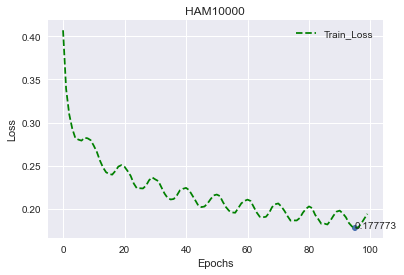

In [17]:
plt.clf()#clear photo
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

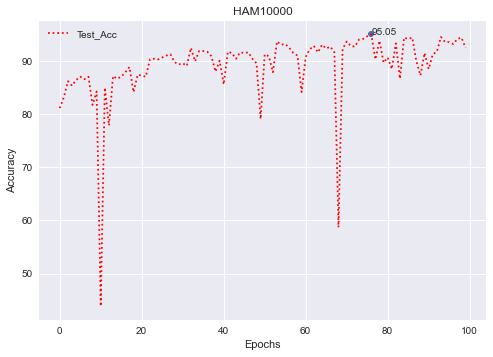

In [18]:
show.test(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

In [19]:
self_scores()

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |   0.9444  | 0.739  | 0.829 |          |
|  bcc   |   0.7027  |  1.0   | 0.825 |          |
|  bkl   |   0.8254  | 0.788  | 0.806 |          |
|   df   |    0.8    | 0.667  | 0.727 |          |
|  mel   |    0.75   | 0.794  | 0.771 |          |
|   nv   |   0.9879  | 0.983  | 0.986 |          |
|  vasc  |    1.0    |  0.9   | 0.947 |          |
| Total: |           |        |       |  0.9505  |
+--------+-----------+--------+-------+----------+


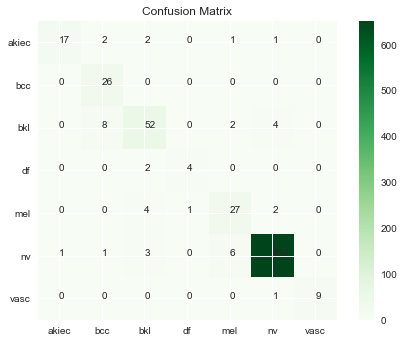

In [20]:
confusion_matrix(evl_result)

In [38]:
num_epochs = 40
network.load_state_dict(torch.load(save_PATH))
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()
print('Finished Training')

Epoch: [1] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17530, ACC:0.71819%
[308/308] Loss0.20560, ACC:0.71485%
Train_Loss: 0.2028123978283498,ACC:0.715%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.58%
Best_ACC[95.29%]
Epoch: [2] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18009, ACC:0.71846%
[308/308] Loss0.21279, ACC:0.71991%
Train_Loss: 0.19927825914187866,ACC:0.721%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.13%
Best_ACC[95.29%]
Epoch: [3] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21084, ACC:0.73009%
[308/308] Loss0.22188, ACC:0.72764%
Train_Loss: 0.19479974146400178,ACC:0.728%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.391%
Best_ACC[95.29%]
Epoch: [4] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19748, ACC:0.73740%
[308/308] Loss0.19373, ACC:0.73678%
Train_Loss: 0.1892843394020161,ACC:0.737%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.237%
Best_ACC[95.29%]
Epoch: [5] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20242, ACC:0.74049%
[308/308] Loss0.18937, ACC:0.74345%
Train_Loss: 0.18414859652712748,ACC:0.744%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.874%
Best_ACC[95.29%]
Epoch: [6] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19085, ACC:0.74950%
[308/308] Loss0.19532, ACC:0.74685%
Train_Loss: 0.1831434667594247,ACC:0.747%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.512%
Best_ACC[95.29%]
Epoch: [7] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18105, ACC:0.74552%
[308/308] Loss0.17423, ACC:0.74581%
Train_Loss: 0.18376244740052658,ACC:0.746%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.237%
Best_ACC[95.29%]
Epoch: [8] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18116, ACC:0.74011%
[308/308] Loss0.17233, ACC:0.74084%
Train_Loss: 0.18756816231391646,ACC:0.741%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.478%
Best_ACC[95.29%]
Epoch: [9] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17947, ACC:0.73609%
[308/308] Loss0.21103, ACC:0.73094%
Train_Loss: 0.19376063080770628,ACC:0.732%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.15%
Best_ACC[95.29%]
Epoch: [10] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21028, ACC:0.72522%
[308/308] Loss0.18629, ACC:0.72192%
Train_Loss: 0.19871490279381926,ACC:0.723%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:80.918%
Best_ACC[95.29%]
Epoch: [11] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20259, ACC:0.71877%
[308/308] Loss0.20704, ACC:0.72045%
Train_Loss: 0.2003338635935412,ACC:0.721%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.734%
Best_ACC[95.29%]
Epoch: [12] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20358, ACC:0.72395%
[308/308] Loss0.21611, ACC:0.72449%
Train_Loss: 0.197522342253428,ACC:0.725%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:32.609%
Best_ACC[95.29%]
Epoch: [13] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18541, ACC:0.73087%
[308/308] Loss0.19436, ACC:0.73085%
Train_Loss: 0.1926569419538046,ACC:0.731%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.874%
Best_ACC[95.29%]
Epoch: [14] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18035, ACC:0.74648%
[308/308] Loss0.17953, ACC:0.74470%
Train_Loss: 0.18524163956572484,ACC:0.745%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.237%
Best_ACC[95.29%]
Epoch: [15] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17730, ACC:0.75170%
[308/308] Loss0.15851, ACC:0.75178%
Train_Loss: 0.17938125999523447,ACC:0.752%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.271%
Best_ACC[95.29%]
Epoch: [16] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15773, ACC:0.75186%
[308/308] Loss0.16954, ACC:0.75008%
Train_Loss: 0.18061222261809684,ACC:0.751%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.357%
Best_ACC[95.29%]
Epoch: [17] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18874, ACC:0.75294%
[308/308] Loss0.17611, ACC:0.75158%
Train_Loss: 0.1804765673330078,ACC:0.752%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.411%
Best_ACC[95.411%]
Epoch: [18] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17408, ACC:0.74776%
[308/308] Loss0.22239, ACC:0.74583%
Train_Loss: 0.18366137925874104,ACC:0.746%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.237%
Best_ACC[95.411%]
Epoch: [19] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19833, ACC:0.73651%
[308/308] Loss0.17877, ACC:0.73626%
Train_Loss: 0.18960372556920174,ACC:0.737%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.754%
Best_ACC[95.411%]
Epoch: [20] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18709, ACC:0.73338%
[308/308] Loss0.14664, ACC:0.72957%
Train_Loss: 0.19427736679261381,ACC:0.73%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.324%
Best_ACC[95.411%]
Epoch: [21] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20492, ACC:0.72874%
[308/308] Loss0.16147, ACC:0.72712%
Train_Loss: 0.19542150997689792,ACC:0.728%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.633%
Best_ACC[95.411%]
Epoch: [22] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19520, ACC:0.72998%
[308/308] Loss0.19918, ACC:0.73120%
Train_Loss: 0.1927203985003682,ACC:0.732%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.686%
Best_ACC[95.411%]
Epoch: [23] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20152, ACC:0.73933%
[308/308] Loss0.21323, ACC:0.73875%
Train_Loss: 0.18819098387445723,ACC:0.739%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.304%
Best_ACC[95.411%]
Epoch: [24] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19177, ACC:0.74992%
[308/308] Loss0.16766, ACC:0.75029%
Train_Loss: 0.181629432824912,ACC:0.751%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[95.411%]
Epoch: [25] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18961, ACC:0.75580%
[308/308] Loss0.21852, ACC:0.75530%
Train_Loss: 0.17745541732806663,ACC:0.756%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.116%
Best_ACC[95.411%]
Epoch: [26] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15994, ACC:0.75626%
[308/308] Loss0.18405, ACC:0.75698%
Train_Loss: 0.1766416315327991,ACC:0.758%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[95.411%]
Epoch: [27] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18046, ACC:0.75819%
[308/308] Loss0.15142, ACC:0.75731%
Train_Loss: 0.17685728873331824,ACC:0.758%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.391%
Best_ACC[95.411%]
Epoch: [28] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15736, ACC:0.75421%
[308/308] Loss0.15880, ACC:0.75334%
Train_Loss: 0.17982033727230964,ACC:0.754%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.802%
Best_ACC[95.411%]
Epoch: [29] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20117, ACC:0.74571%
[308/308] Loss0.19321, ACC:0.74198%
Train_Loss: 0.187121393667026,ACC:0.743%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.444%
Best_ACC[95.411%]
Epoch: [30] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20277, ACC:0.73508%
[308/308] Loss0.15154, ACC:0.73572%
Train_Loss: 0.19067147930527661,ACC:0.736%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.633%
Best_ACC[95.411%]
Epoch: [31] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20964, ACC:0.73160%
[308/308] Loss0.18827, ACC:0.73208%
Train_Loss: 0.19265532314583853,ACC:0.733%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.493%
Best_ACC[95.411%]
Epoch: [32] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15322, ACC:0.73937%
[308/308] Loss0.18098, ACC:0.73771%
Train_Loss: 0.1896606462632681,ACC:0.738%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.203%
Best_ACC[95.411%]
Epoch: [33] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16172, ACC:0.74934%
[308/308] Loss0.16440, ACC:0.74581%
Train_Loss: 0.1843233954209786,ACC:0.746%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.391%
Best_ACC[95.411%]
Epoch: [34] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16607, ACC:0.75317%
[308/308] Loss0.19822, ACC:0.75406%
Train_Loss: 0.17976553017249355,ACC:0.755%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[95.411%]
Epoch: [35] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18435, ACC:0.76245%
[308/308] Loss0.16432, ACC:0.76117%
Train_Loss: 0.17453493119834304,ACC:0.762%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.908%
Best_ACC[95.411%]
Epoch: [36] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16876, ACC:0.76167%
[308/308] Loss0.15178, ACC:0.76063%
Train_Loss: 0.17448097031998944,ACC:0.761%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.391%
Best_ACC[95.411%]
Epoch: [37] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15981, ACC:0.76190%
[308/308] Loss0.18218, ACC:0.76229%
Train_Loss: 0.17408670044758104,ACC:0.763%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[95.411%]
Epoch: [38] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19467, ACC:0.75692%
[308/308] Loss0.21309, ACC:0.75746%
Train_Loss: 0.1773866091842775,ACC:0.758%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.928%
Best_ACC[95.411%]
Epoch: [39] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20774, ACC:0.75085%
[308/308] Loss0.19206, ACC:0.74778%
Train_Loss: 0.18373886640969808,ACC:0.748%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.135%
Best_ACC[96.135%]
Epoch: [40] HAM10000 ==> Training ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17560, ACC:0.74304%
[308/308] Loss0.17906, ACC:0.74186%
Train_Loss: 0.18781698117782544,ACC:0.743%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.942%
Best_ACC[96.135%]
Finished Training


In [40]:
self_scores()

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |   0.8333  |  0.87  | 0.851 |          |
|  bcc   |   0.875   | 0.808  |  0.84 |          |
|  bkl   |   0.8788  | 0.879  | 0.879 |          |
|   df   |   0.5714  | 0.667  | 0.615 |          |
|  mel   |   0.9118  | 0.912  | 0.912 |          |
|   nv   |   0.9835  | 0.988  | 0.986 |          |
|  vasc  |    1.0    |  0.7   | 0.824 |          |
| Total: |           |        |       |  0.9614  |
+--------+-----------+--------+-------+----------+


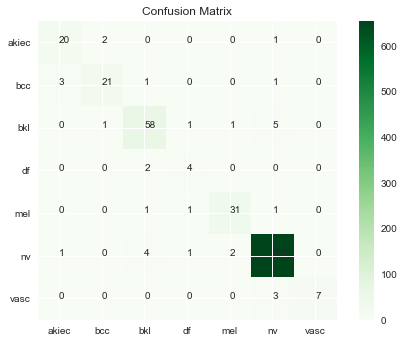

In [41]:
confusion_matrix(evl_result)

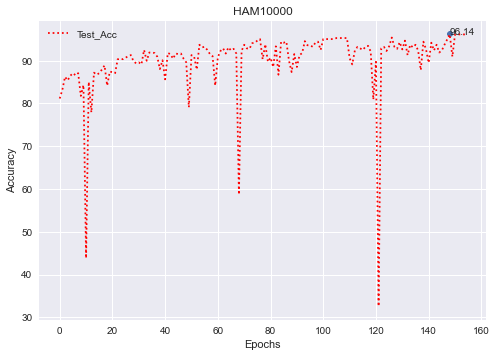

In [42]:
show.test(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

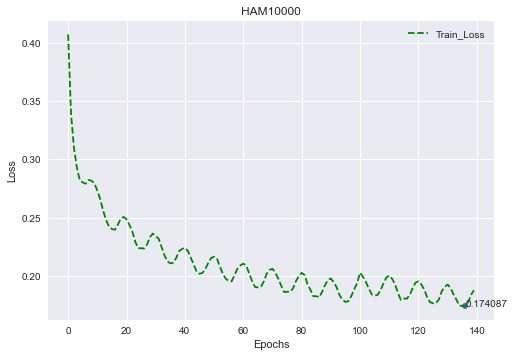

In [43]:
plt.clf()#clear photo
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

In [44]:
# #save
s1 = np.array(test_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_test_acc_{suf}.npy', s1)
s2 = np.array(train_loss_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_loss_{suf}.npy', s2)

In [45]:
torch.cuda.memory.empty_cache()

In [28]:
# num_epochs = 45
# network.load_state_dict(torch.load(save_PATH))
# for epoch in range(1, num_epochs + 1):
#     train(epoch)
#     test()
# print('Finished Training')

In [29]:
# self_scores()

In [30]:
# confusion_matrix(evl_result)

In [31]:
# show.conclusion(img_title=img_title)

In [32]:
# torch.cuda.memory.empty_cache()

In [33]:
# # #save
# s1 = np.array(test_acc_list)
# np.save(f'./tmp/{img_title}/{suf}/{img_title}_test_acc_{suf}.npy', s1)
# s2 = np.array(train_loss_list)
# np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_loss_{suf}.npy', s2)